## Driver drowsiness detection system

In [2]:
# Importing the necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data processing, including CSV file I/O
import os  # For interacting with the operating system
import cv2  # OpenCV library for computer vision tasks
import warnings  # For handling warnings
warnings.filterwarnings('ignore')  # Ignore warnings to prevent clutter in the output

### Data Collection
The dataset used in this project is the 'drowsiness-dataset', open source data which is specifically curated for detecting drowsiness through eye and mouth state analysis. This dataset is ideal for our purpose as it contains labeled images categorized into four classes: 'Closed', 'Open', 'yawn', and 'no_yawn'. These labels directly correlate with the signs of drowsiness, making the dataset highly relevant for our task.

### Data Exploration and Extraction

In [3]:
# Retrieve a list of labels or categories from the "./train" directory
labels = os.listdir("../input/train")

In [4]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

#### Let's explore the dataset 

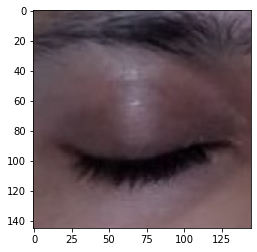

In [5]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("../input/train/Closed/_0.jpg"))

#### Check the size of the image

In [6]:
a = plt.imread("../input/train/yawn/10.jpg")

In [7]:
a.shape

(480, 640, 3)

### Visualizing Yawn Images
In this section, we are exploring the dataset, specifically focusing on yawn images. Our objective is to extract only the facial features from these images, as the background information is unnecessary for our analysis. We are interested in isolating and working with the driver's facial expressions, particularly when they exhibit signs of yawning.

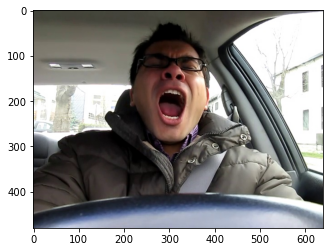

In [8]:
plt.imshow(plt.imread("../input/train/yawn/34.jpg"))

#### Feature Extraction and Resize for yawn and no_yawn 

Our approach involves utilizing Haar Cascade classifiers for accurate facial region detection, allowing us to remove unnecessary background information and focus on the driver's facial expressions. The goal is to prepare a dataset that isolates facial expressions, which will be instrumental for our model.

We are implementing this process for two categories:
1. "yawn" - Images containing drivers with yawning expressions.
2. "no_yawn" - Images of drivers without yawning expressions.

Let's break down the code step by step and explain its functionality:

In [9]:
def face_for_yawn(direc="../input/train", face_cas_path="../input/haarcascade_frontalface_default.xml"):
    # Initialize an empty list to store the image data and labels
    yaw_no = []
    IMG_SIZE = 145  # Standard size for resizing images
    categories = ["yawn", "no_yawn"]  # Categories to loop through

    # Loop through the two categories: 'yawn' and 'no_yawn'
    for category in categories:
        path_link = os.path.join(direc, category)  # Path to the category directory
        class_num1 = categories.index(category)  # Assign a numerical label to each category (0 or 1)
        print(class_num1)

        # Loop through each image in the category directory
        for image in os.listdir(path_link):
            # Read the image in color
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            
            # Load the Haar Cascade for face detection
            face_cascade = cv2.CascadeClassifier(face_cas_path)

            # Detect faces in the image
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)

            # Loop through the faces detected in the image
            for (x, y, w, h) in faces:
                # Draw a rectangle around each face (not necessary for training, but useful for visualization)
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)

                # Extract the region of interest (the face) from the image
                roi_color = img[y:y+h, x:x+w]

                # Resize the extracted face to the standard size
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))

                # Append the resized face and its label to the list
                yaw_no.append([resized_array, class_num1])

    # Return the compiled list of images and labels
    return yaw_no

#### Image Resize for Open and Close eye.

In the below code, we resize the image for the open and close eyes. We don't need to do a background removal as the images only show the eyes, we have seen this in the above exploration. 

In [10]:
def get_eyes_data(dir_path="../input/train"):
    # Define the labels for the two classes: 'Closed' and 'Open'
    labels = ['Closed', 'Open']
    IMG_SIZE = 145  # Define standard image size for resizing
    data = []  # Initialize an empty list to store the image data and labels

    # Loop through the two labels ('Closed' and 'Open')
    for label in labels:
        path = os.path.join(dir_path, label)  # Construct path to the label's directory
        class_num = labels.index(label)  # Get index of the label
        class_num += 2  # Offset class number by 2 (for distinct labeling from yawn/no_yawn)
        print(class_num)  # Print the class number for debugging

        # Loop through each image in the label's directory
        for img in os.listdir(path):
            try:
                # Read and load the image in color mode
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)

                # Resize the image to the specified IMG_SIZE
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

                # Append the resized image and its class label to the data list
                data.append([resized_array, class_num])
            except Exception as e:
                # Print any exceptions that occur during image processing
                print(e)

    # Return the list of processed images and their labels
    return data

#### Now we create a function to help us combine all of the type of images into one NumPy array and store the combined data into a new lists, as features and labels. We print the class label numbers for debugging purpose. 

In [11]:
def append_data():
    yaw_no = face_for_yawn()  # This should return a list of [image, label] pairs
    data = get_eyes_data()    # This also should return a list of [image, label] pairs

    # Combine the two datasets
    total_data = yaw_no + data

    # Separate features (images) and labels
    features = [item[0] for item in total_data]  # Extract the first element (image) from each pair
    labels = [item[1] for item in total_data]   # Extract the second element (label) from each pair

    # Convert lists to NumPy arrays
    features_array = np.array(features)
    labels_array = np.array(labels)

    return features_array, labels_array

new_features, new_labels = append_data()

0
1
2
3


#### Then we separate the features/images and labels 

In [12]:
# Extracting features and labels from the 'new_data' dataset
X = new_features  # List to store features
y = new_labels  # List to store labels

#### We reshape the features

In [13]:
# Convert the 'X' list of features into a NumPy array
X = np.array(X)

# Reshape the 'X' array into a 4D tensor with dimensions (batch_size, height, width, channels)
X = X.reshape(-1, 145, 145, 3)

### LabelBinarizer
Label Binarization is a technique used to convert categorical class labels into binary values. It's essential for:

1. **Binary Classification:** Converting multi-class labels to binary (0 and 1) format, making it suitable for binary classification tasks.

2. **Algorithm Compatibility:** Ensuring that machine learning algorithms can work with numerical labels, as many require this format.

3. **Evaluation Metrics:** Simplifying the calculation of metrics like precision, recall, and F1-score that expect binary labels.

In the code below, `LabelBinarizer` is used to perform Label Binarization on the 'y' labels, preparing them for classification.

In [14]:
# Perform Label Binarization for Classification Labels
# Import the LabelBinarizer from Scikit-Learn
from sklearn.preprocessing import LabelBinarizer

# Initialize a LabelBinarizer instance
label_bin = LabelBinarizer()

# Apply Label Binarization to transform the categorical labels 'y' into binary format
y = label_bin.fit_transform(y)

In [15]:
# Convert Binary Labels to NumPy Array
# Convert the binary labels 'y' to a NumPy array for compatibility with machine learning libraries and models
y = np.array(y)

## Model Development and Training 

### Train Test split

In [16]:
# Splitting the Dataset into Training and Testing Sets
# Import the train_test_split function from Scikit-Learn to split the dataset
from sklearn.model_selection import train_test_split

# Set a fixed random seed for reproducibility
seed = 42

# Define the proportion of data to allocate to the testing set (30% in this case)
test_size = 0.30

# Use train_test_split to split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

### Import relevant dependencies

In [17]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

### Data Augmentation

Data augmentation significantly enhances the generalization capabilities of image classification models, particularly useful in applications like driver drowsiness detection. It effectively combats overfitting by introducing varied transformations to the training dataset, simulating real-world conditions and creating a more balanced dataset. This approach not only improves model robustness but also offers a cost-effective solution to enriching the dataset without the need for additional image collection and labeling.

In [18]:
# Data Augmentation and Preprocessing for Training and Testing Sets

# Import the necessary libraries for image data augmentation
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Data Augmentation for Training Set
# - Rescale pixel values to a range between 0 and 1
# - Apply random zoom with a range of 20%
# - Apply horizontal flip for additional training variation
# - Rotate images within a range of 30 degrees
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)

# Data Preprocessing for Testing Set
# - Rescale pixel values to a range between 0 and 1
test_generator = ImageDataGenerator(rescale=1/255)

# Create Data Generators
# - Apply the data augmentation and preprocessing transformations to the respective datasets
# - Shuffle is set to False to maintain data order, which is important for evaluation
train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

### Model Architecture

The chosen Convolutional Neural Network (CNN) architecture for the driver drowsiness system is a well-suited choice for image classification tasks, as it excels at learning and extracting relevant features from input images. By using multiple convolutional layers followed by max-pooling operations, the model can capture intricate patterns and spatial information from the facial images, making it effective at discerning signs of drowsiness. Additionally, the inclusion of a dropout layer helps mitigate overfitting, enhancing the model's generalization capability. The final softmax activation layer enables multi-class classification, which is suitable for detecting various levels of drowsiness. The model's effectiveness hinges on the quality and quantity of the training data and the careful tuning of hyperparameters. Through extensive training and evaluation on representative datasets, the model's ability to accurately identify driver drowsiness can be assessed, making it a promising tool for enhancing road safety

#### Hyperparameter tuning 

In [19]:
# CNN Model for Image Classification (Driver Drowsiness Detection)

# Initialize a Sequential model
model = Sequential()

# Convolutional Layer 1: 256 filters, (3x3) kernel size, ReLU activation, input shape determined by X_train
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))  # MaxPooling layer for down-sampling

# Convolutional Layer 2: 128 filters, (3x3) kernel size, ReLU activation
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

# Convolutional Layer 3: 64 filters, (3x3) kernel size, ReLU activation
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

# Convolutional Layer 4: 32 filters, (3x3) kernel size, ReLU activation
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

# Flatten Layer to convert the 2D feature maps into a 1D vector
model.add(Flatten())

# Dropout Layer for regularization to prevent overfitting
model.add(Dropout(0.5))

# Fully Connected Layer 1: 64 neurons, ReLU activation
model.add(Dense(64, activation="relu"))

# Output Layer with 4 neurons and softmax activation for multi-class classification
model.add(Dense(4, activation="softmax"))

# Compile the model with categorical cross-entropy loss, accuracy metric, and Adam optimizer
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Display a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

Before fitting our model, we implemented early stopping to prevent overfitting as part of our optimization effort. Early stopping was used in your model training as a form of regularization to prevent overfitting, a common challenge in deep learning models. By monitoring the model's performance on a validation set, it halts the training process when the performance ceases to improve, thereby saving computational resources and time.

In [20]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [21]:
# Model Training and History Tracking

# Train the 'model' using the training data generator 'train_generator'
# - Perform training for 50 epochs (adjustable)
# - Use the validation data generator 'test_generator' for validation during training
# - Shuffle the training data for randomness
# - Set the number of validation steps to the length of the test generator
history = model.fit(train_generator, epochs=50, validation_data=test_generator, 
                    shuffle=True, validation_steps=len(test_generator), callbacks=[early_stopping])

Epoch 1/50
43/43 [==============================] - 242s 5s/step - loss: 1.0416 - accuracy: 0.5602 - val_loss: 0.4983 - val_accuracy: 0.8024
Epoch 2/50
43/43 [==============================] - 262s 6s/step - loss: 0.5010 - accuracy: 0.7860 - val_loss: 0.4681 - val_accuracy: 0.8111
Epoch 3/50
43/43 [==============================] - 260s 6s/step - loss: 0.3997 - accuracy: 0.8410 - val_loss: 0.2954 - val_accuracy: 0.8908
Epoch 4/50
43/43 [==============================] - 265s 6s/step - loss: 0.3523 - accuracy: 0.8492 - val_loss: 0.3107 - val_accuracy: 0.8925
Epoch 5/50
43/43 [==============================] - 244s 6s/step - loss: 0.3062 - accuracy: 0.8774 - val_loss: 0.2527 - val_accuracy: 0.9064
Epoch 6/50
43/43 [==============================] - 244s 6s/step - loss: 0.3137 - accuracy: 0.8670 - val_loss: 0.2484 - val_accuracy: 0.9064
Epoch 7/50
43/43 [==============================] - 231s 5s/step - loss: 0.2630 - accuracy: 0.8945 - val_loss: 0.2200 - val_accuracy: 0.9133
Epoch 8/50
43

As we can see above, the training stopped at epoch 47/50. That's to prevent overfitting as we have applied early stopping. 

### Model Evaluations 

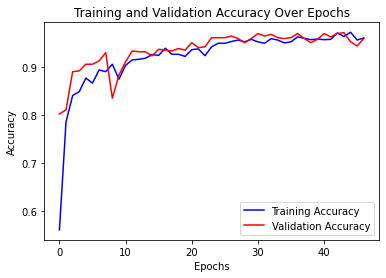

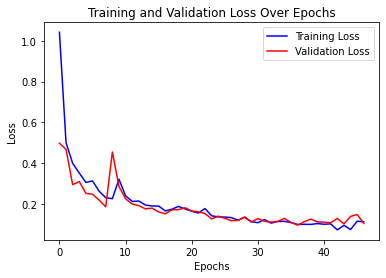

19/19 [==============================] - 13s 690ms/step
Mean Absolute Error (MAE): 0.10745233968804159
Root Mean Squared Error (RMSE): 0.33820814404767563


In [23]:
# Plotting Training and Validation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract training and validation accuracy and loss values from the training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# Plot Training and Validation Accuracy
plt.plot(epochs, accuracy, "b", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# Plot Training and Validation Loss
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Predictions to calculate MAE and RMSE
predictions = model.predict(X_test)
# Convert predictions and y_test to the same shape for MAE and RMSE calculations
y_test_actual = np.argmax(y_test, axis=1)
predictions_actual = np.argmax(predictions, axis=1)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_actual, predictions_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

### Save model

In [24]:
model.save("../input/drowiness_detection_system_model.h5")

### Prediction

In [25]:
# Use the predict method to get the array of class probabilities
predictions = model.predict(X_test)

# Convert probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

19/19 [==============================] - 13s 678ms/step


In [26]:
predicted_classes

array([2, 3, 2, 3, 0, 2, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 3, 1, 0, 3, 3, 2,
       3, 1, 1, 3, 3, 3, 3, 2, 2, 3, 3, 3, 0, 3, 3, 2, 0, 3, 2, 3, 3, 2,
       3, 2, 3, 3, 2, 2, 3, 1, 2, 0, 3, 2, 2, 2, 3, 0, 3, 3, 0, 2, 2, 3,
       3, 3, 2, 2, 1, 3, 2, 3, 2, 0, 0, 3, 0, 3, 2, 0, 3, 2, 3, 3, 2, 0,
       2, 3, 2, 3, 3, 2, 0, 0, 3, 0, 2, 2, 2, 0, 3, 0, 2, 3, 3, 0, 2, 2,
       1, 1, 3, 0, 0, 3, 3, 3, 3, 3, 3, 2, 3, 1, 1, 3, 3, 3, 2, 0, 2, 2,
       1, 3, 0, 2, 3, 3, 3, 1, 3, 2, 3, 0, 2, 2, 3, 2, 2, 0, 3, 2, 2, 2,
       3, 1, 1, 0, 3, 0, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 1, 2, 0, 2, 3,
       2, 2, 0, 3, 2, 0, 3, 0, 3, 3, 3, 0, 2, 0, 2, 3, 3, 2, 2, 2, 2, 0,
       2, 2, 2, 0, 3, 0, 0, 1, 3, 2, 2, 0, 3, 0, 2, 2, 2, 3, 1, 3, 1, 0,
       0, 0, 2, 3, 2, 2, 3, 2, 0, 2, 0, 0, 3, 3, 1, 2, 3, 0, 3, 3, 0, 1,
       0, 0, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 0, 3, 3, 2, 0, 2, 3, 2, 3,
       2, 3, 2, 0, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 0, 0, 1, 2, 3, 3, 3, 2,
       3, 1, 2, 2, 2, 3, 2, 0, 3, 3, 0, 2, 2, 3, 1,

### Classification report

#### Performance Analysis

Class-wise Performance:
- Yawn: This class has a precision of 0.58 and a recall of 0.89. The high recall indicates that the model is good at identifying most of the 'Yawn' cases, but the lower precision suggests it also misclassifies quite a few non-yawn instances as yawn.
- No Yawn: Shows a precision of 0.84 but a lower recall of 0.44. This means while the model is quite accurate when it predicts 'No Yawn', it misses more than half of the actual 'No Yawn' cases.
- Closed: High precision (0.96) and recall (0.97) indicate excellent performance in identifying closed eyes.
- Open: Similar to 'Closed', the 'Open' class shows very high precision and recall, suggesting the model performs very well in identifying open eyes.

- Overall Accuracy:
The model has an overall accuracy of 90%, which is generally good. However, this number might be misleading as it is more influenced by the model's performance on the more numerous classes ('Closed' and 'Open').

- Macro and Weighted Averages:
The macro average (which treats all classes equally) is lower than the weighted average (which considers class imbalance), indicating that the model performs better on more frequent classes.

#### Potential Issues and Improvement Strategies 

Our model shows promising results, particularly in identifying 'Open' and 'Closed' eye states. However, there's room for improvement, especially in the 'Yawn' and 'No Yawn' categories. Addressing class imbalance, refining the model architecture, and conducting detailed error analysis are key steps towards enhancing the model's overall performance and reliability. Due to time constraints, it's impossible to re-train the model implementing the imporvement strategies we mentioned, but in future work we will improve the model to perform better.   

In [27]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [28]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), predicted_classes, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.58      0.89      0.70        63
     no_yawn       0.84      0.44      0.58        72
      Closed       0.96      0.97      0.97       212
        Open       0.98      0.97      0.97       230

    accuracy                           0.90       577
   macro avg       0.84      0.82      0.81       577
weighted avg       0.91      0.90      0.89       577



### Thank you!!! 